[*********************100%***********************]  1 of 1 completed
c:\Users\omar\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0028 - val_loss: 0.0011
Epoch 2/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 3.3578e-04 - val_loss: 9.4657e-04
Epoch 3/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 3.4453e-04 - val_loss: 5.5511e-04
Epoch 4/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 2.6635e-04 - val_loss: 0.0043
Epoch 5/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 2.3425e-04 - val_loss: 0.0014
Epoch 6/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 2.1096e-04 - val_loss: 0.0013
Epoch 7/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 2.1256e-04 - val_loss: 8.3846e-04
Epoch 8/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 2.2521e-04 - val_loss: 2.9712e-04
Epoch 9/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 1.7538e-04 - val_loss: 4.6146e-04
Epoch 10/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 1.3106e-04 - val_loss: 7.3584e-04
Epoch 11/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 1.9823e

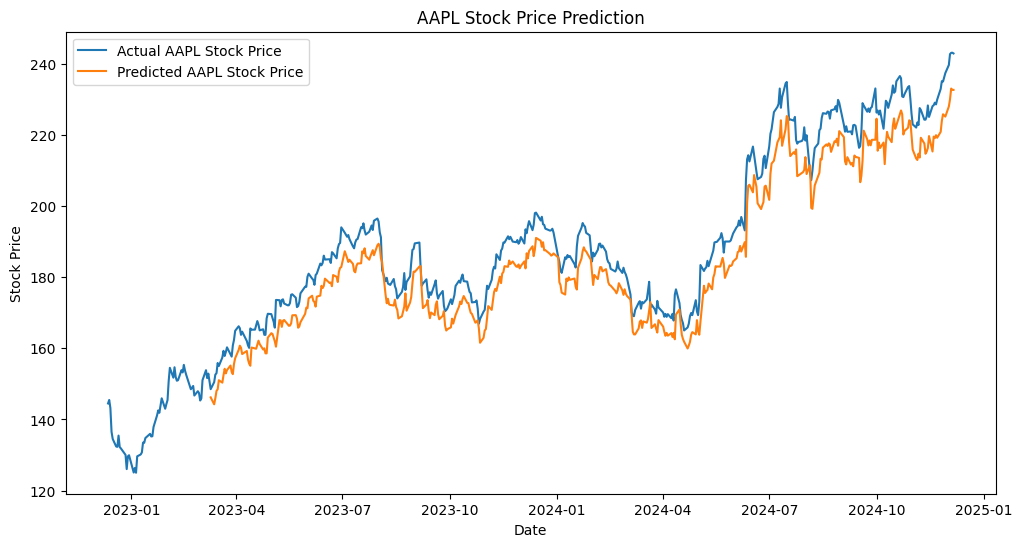

RMSE: 185.77605514519854, MAE: 184.5828502296138, R2: -3275522.4241026985


In [1]:
import yfinance as yf
from datetime import datetime
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Fetch AAPL data from Yahoo Finance for the entire period from 2015 to the present
start_date = '2015-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')

aapl_stock = yf.download('AAPL', start=start_date, end=end_date)

# Set Date as index if not already
if 'Date' not in aapl_stock.columns:
    aapl_stock['Date'] = aapl_stock.index
aapl_stock.set_index('Date', inplace=True)

aapl_prices = aapl_stock['Close'].values.reshape(-1, 1)

# Scale data
scaler = MinMaxScaler()
aapl_prices_scaled = scaler.fit_transform(aapl_prices)

# Split data into training and testing sets (80% train, 20% test)
train_size = int(len(aapl_prices_scaled) * 0.8)
train_data = aapl_prices_scaled[:train_size]
test_data = aapl_prices_scaled[train_size:]

# Create sequences for LSTM model
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 60
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
model.fit(X_train, y_train, batch_size=8, epochs=20, validation_data=(X_test, y_test))

# Make predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(aapl_stock.index[train_size:], aapl_stock['Close'][train_size:], label='Actual AAPL Stock Price')
plt.plot(aapl_stock.index[train_size + seq_length:], predictions, label='Predicted AAPL Stock Price')
plt.title('AAPL Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Evaluate model performance
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"RMSE: {rmse}, MAE: {mae}, R2: {r2}")

evaluate_model(y_test, predictions)
